In [1]:
import os.path

import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
import torchvision.utils

import seaborn as sns

#import  umap
from sklearn.manifold import TSNE

from torch import nn, optim
from torch.nn import functional
from torchvision import datasets, transforms

In [2]:
# Select GPU if available.
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))

# Set seed.
torch.manual_seed(42)

# Prepare data.
train_loader = torch.utils.data.DataLoader(datasets.FashionMNIST(
    "data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
), batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.FashionMNIST(
    "data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
), batch_size=128, shuffle=True)

In [3]:
class VAE(nn.Module):
    def __init__(self, input_shape, device, width, latent_dimensionality, ):
        super(VAE, self).__init__()
        self.input_shape = input_shape
        self.n_input_values = np.prod(input_shape).item()
        self.device = device
        self.width = width
        self.latent_dimensionality = latent_dimensionality

        # Define encoding layers.
        self.input_encoder = nn.Linear(in_features=self.n_input_values, out_features=self.width)
        self.mean_encoder = nn.Linear(in_features=self.width, out_features=self.latent_dimensionality)
        self.var_encoder = nn.Linear(in_features=self.width, out_features=self.latent_dimensionality)

        # Define decoding layers.
        self.latent_decoder = nn.Linear(in_features=self.latent_dimensionality, out_features=self.width)
        self.final_decoder = nn.Linear(in_features=self.width, out_features=self.n_input_values)

    def encode(self, original):
        encoded_input = functional.relu(self.input_encoder(original))
        return self.mean_encoder(encoded_input), self.var_encoder(encoded_input)

    def reparameterize(self, mean, log_variance):
        deviation = torch.exp(0.5 * log_variance)
        noise = torch.randn_like(deviation, device=self.device)
        return mean + noise * deviation

    def decode(self, latent):
        decoded_latent = functional.relu(self.latent_decoder(latent))
        final = torch.sigmoid(self.final_decoder(decoded_latent))
        # reshape
        return final.view(-1, *self.input_shape)

    def forward(self, original):
        mean, log_variance = self.encode(original.view(-1, self.n_input_values))
        latent = self.reparameterize(mean, log_variance)
        decoded = self.decode(latent)
        return decoded, mean, log_variance

    def variational_loss_function(self, decoded, original, mean, log_variance) -> torch.Tensor:
        entropy = functional.binary_cross_entropy(decoded, original.view(-1, *self.input_shape), reduction="sum", )

        divergence = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())

        return entropy + divergence

In [4]:
def train(model, train_data, test_data, n_epochs=20, learning_rate=1e-3):
    n_batches = len(train_data)
    
    # Preprae optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Prepare history
    history_train = np.zeros(n_epochs)
    history_test = np.zeros(n_epochs)
    
    # Prepare latent space
    
    for i_epoch in range(n_epochs):
        
        print(i_epoch)
        
        # tell model that training starts
        model.train()
        
        total_loss = 0.0
        
        for i_batch, (batch, label) in enumerate(train_data):
            
            # send data to device
            batch = batch.to(device)
            
            # reset optimizer
            optimizer.zero_grad()
            
            # call forward on model with the current batch
            reconstruction, mean, log_variance = model(batch)
            
            # calculate loss of the batch
            loss = model.variational_loss_function(reconstruction, batch, mean, log_variance)
            
            total_loss += loss
            
            # calculate gradient and update model
            loss.backward()
            optimizer.step()
            
        history_train[i_epoch] = total_loss / n_batches
        
        history_test[i_epoch] = test(model, test_data)
        
    
    return history_train, history_test

In [5]:
def test(model, test_data):
    n_batches = len(test_data)


    # tell model that testing starts
    model.eval()

    total_loss = 0
    with torch.no_grad():
        for i_batch, (batch, label) in enumerate(test_data):
            batch = batch.to(device)
            reconstruction, mean, log_variance = model(batch)
            loss = model.variational_loss_function(reconstruction, batch, mean, log_variance)
            total_loss += loss
    
    return total_loss / n_batches

In [6]:
def plot_loss(data, label, title, n_epochs=20):
    
    epochs = range(1,n_epochs + 1)
    
    for d, l in zip(data, label):
        plt.plot(epochs, d, label=l)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
model = VAE(input_shape=[1, 28, 28], width=400, latent_dimensionality=20,
                device=device).to(device)
train_history, test_history = train(model, train_data=train_loader, test_data=test_loader, n_epochs=20)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


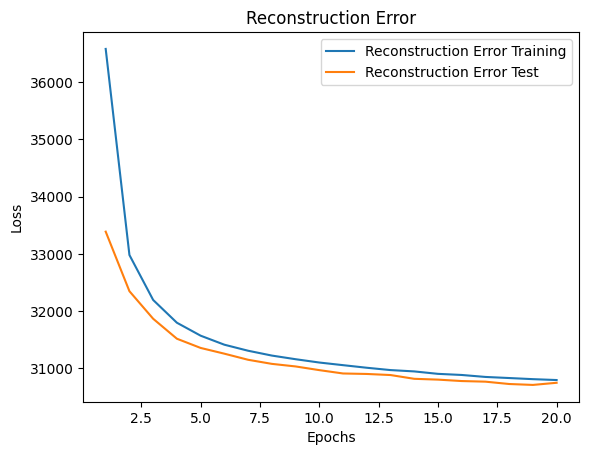

In [8]:
plot_loss([train_history, test_history], ['Reconstruction Error Training', 'Reconstruction Error Test'], 'Reconstruction Error', n_epochs=20)

torch.Size([128, 20])


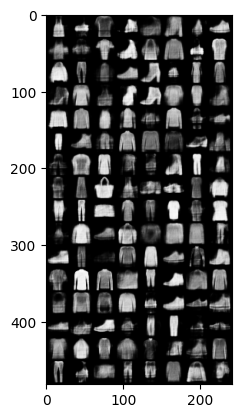

In [60]:
# Prepare random latent to observe progress.
fixed_latent = noise = torch.randn([128, 20], device=device)

print(fixed_latent.shape)

# Process fixed latent.
decoded = model.decode(fixed_latent)

grid = torchvision.utils.make_grid(
    decoded
)
plt.imshow(grid.permute(1, 2, 0))
#path = os.path.join(
#    out_path,
#    f"random-{i_epoch:0{len(str(n_epochs))}}"
#    f"-{i_batch:0{len(str(n_batches))}}"
#    f".{image_extension}",
#)
#torchvision.utils.save_image(grid, path)

In [61]:
train_loader = torch.utils.data.DataLoader(datasets.FashionMNIST("data", train=True, download=True, transform=transforms.ToTensor()), batch_size=60000)

# reducer = umap.UMAP()

labels = []
batches = []
latents = []

for batch, label in train_loader:

    labels = label

    batches = batch.to(device)
    
    mean, log_variance = model.encode(batches.view(-1, np.prod([1,28,28]).item()))
    latents = model.reparameterize(mean, log_variance)

    # embedding = reducer.fit_transform(latent.cpu().detach().numpy())
    embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(latents.cpu().detach().numpy())
    print(embedding.shape)
    

(60000, 2)


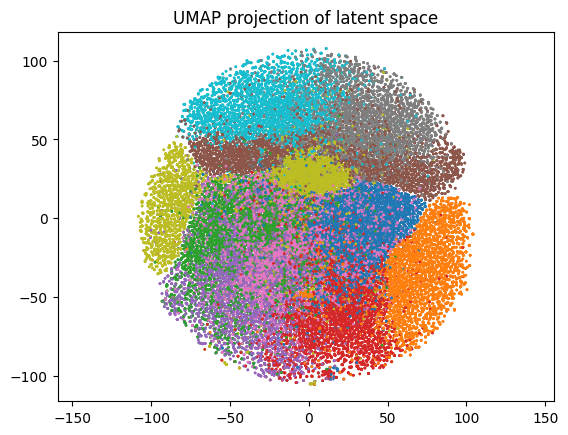

In [62]:
#to = 9
#from_p = 0

#print(batches[0])
#print(batches[8])

#for i in range(from_p,to):
#    print(i, embedding[i, 0], embedding[i, 1])
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in labels[:]],
    s=1
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of latent space');

In [74]:
def image_from_latent(fixed_latent):
    decoded = model.decode(fixed_latent)

    grid = torchvision.utils.make_grid(
        decoded
    )
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()

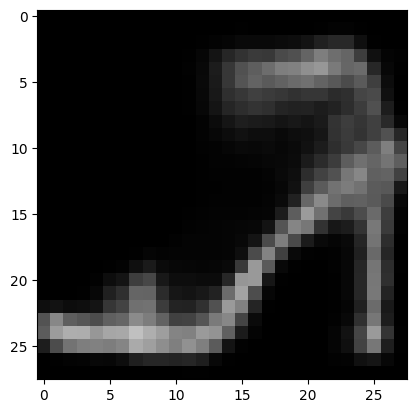

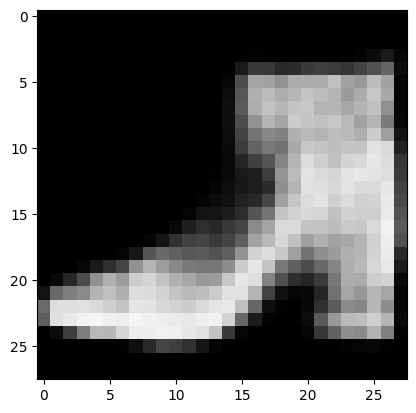

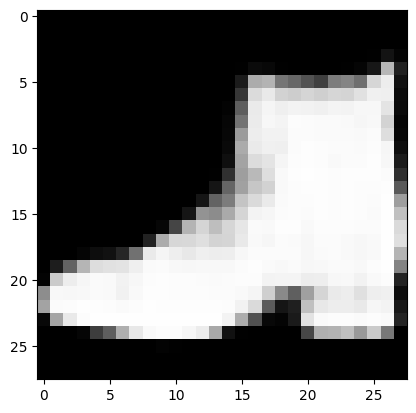

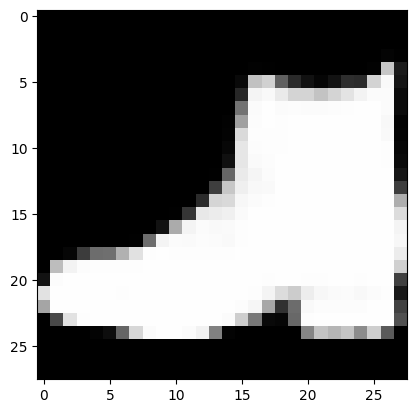

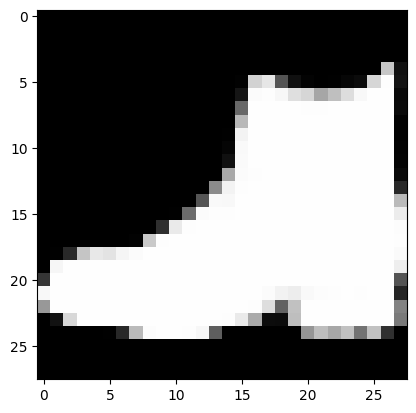

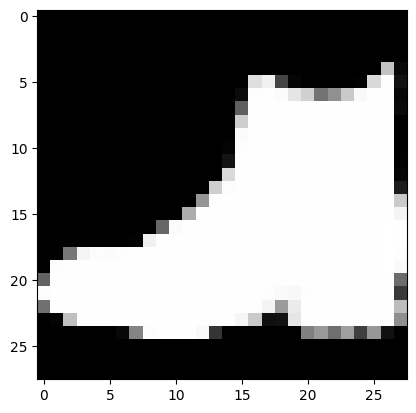

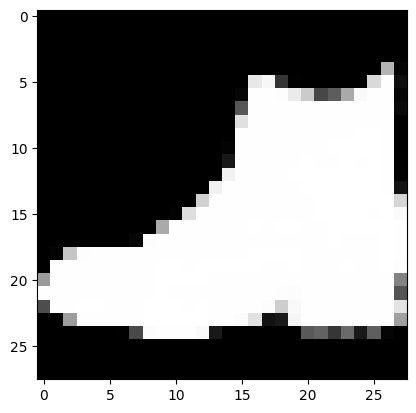

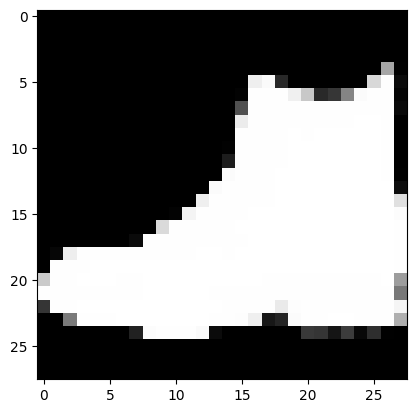

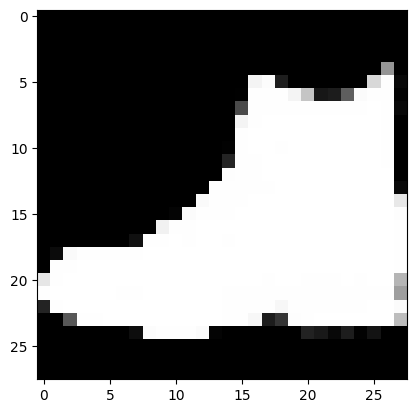

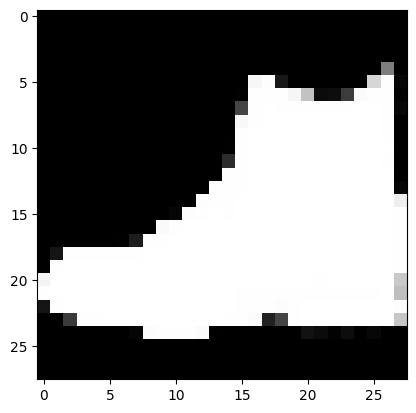

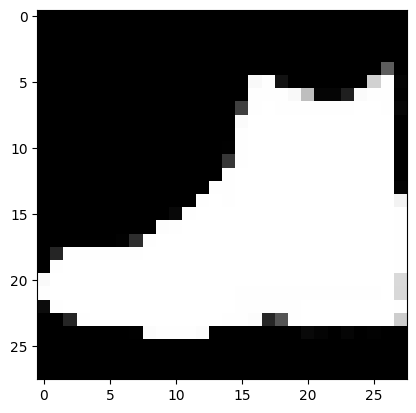

In [83]:
difference = latents[0] - latents[8] / 100

gen_latent = latents[8]
for _ in range(10):
    image_from_latent(gen_latent)
    gen_latent = gen_latent + difference
image_from_latent(gen_latent)